In [1]:
"""

hear ye hear ye
Robb, Abigail M
​Faulkner, Jonathon M
Hark hark,

I bid thee this most recent and updated message:

Its taking my laptop 2.5 minutes to run

"""







## cell for imports
import numpy as np
import matplotlib.pyplot as plt






## Step 1. Calculate the scalar flux
        ### a. DEFINE A FUNCTION  ->
def compute_scalar_flux(psi, weights, mu):

    # psi is a dict where keys are values of mu and the values are vectors corresponding to psi at points in space
    # weights are just weights for Sn
    # mu are angles - mu is also the keys for the psi dict.
    # this FUNCTION is like a mini program that will help us preform a specific task
    #    ## psi is a dictionary, where the key is a list/array of numbers repreesnting the flux at different spatial locations for that angle
    # scalar flux equation: scalar_flux(x) = SUM( psi(mu,x) * weight[mu] )

        ### b. PREPARE AN EMPTY RESULT   ->
    # first set up a dummy value for scalar flux using the length of psi at the first angle

    first_mu = mu[0]            #this line takes the first angle from the list mu, where 0 is indicative of the first 'index'
    length_of_psi = len(psi[first_mu])  # gets the length of psi for the first angle i.e.  this tells us how many values are in the flux list for this first mu, or how many spatial locations there are
    scalar_flux = np.zeros(length_of_psi)  # initialize the scalar flux array with zeros (i.e. there are 10 values in this flux list, and they are all zero)


         ### c. LOOP OVER EACH DISCRETE ANGLE AND ADD THE WEIGHTED ANG FLUX TO THE SCALAR FLUX

    for idx, this_mu in enumerate(mu):      # for each angle in mu
        this_weight = weights[idx]       # take the weight corresponding to the current angle
        this_psi = psi[this_mu]      # retrieve the flux value for the current angle in the dictionary
        scalar_flux = scalar_flux + this_weight * this_psi   #eqn to calc scalar flux, take the flux val for this angle, mult every value in the list by the weight, and add it to the existing result for scalar flux. (kind of like adding another layer from one direction) it is repeated for all angles, so that each contribution from each angle is added

        ### d. RETURN COMBINED RESULT     ->

    return scalar_flux    #now the function vies the combined weighted fluxvalues at each spatial location



        ### e. TEST THE FUNCTION,   ->

psi = {}           # start by defining psi as our empty dictionary

#using a set of SN Ws and Mus for S4 approx, as described in Rahnema's notes for 1D SN Method
mu = np.array([0.34, 0.8611, -0.34, -0.8611])
weight = np.array([0.6522, 0.3479, 0.6522, 0.3479])  # essentially tells us how 'important' eaach direction is when calculating the scalar flux



# the most simple initial guess for scalar flux psi at all angles is ten 1s

for idx, this_mu in enumerate(mu):
    psi[this_mu] = np.ones(10)     #1 ten times



# calculate the initial scaalar flux using the function that was just defined
initial_scalar_flux = compute_scalar_flux(psi=psi, weights=weight, mu=mu)   # the result is saved in initial_scalar_flux, and you can also write this as just compute_scalar_flux(psi, weight, mu)
print('The initial scalar flux is:', initial_scalar_flux)

## Step 2. Make a mesh and show data for each region
    # this is a 1D grid that divides the slab into smaller segments.... each region/cell has itsown properties (abs, scat etc values) with a certain width.
      #gerenally you calc the center of each cell where you would calc a result, the width of the cells, and the values of absorption, scat
    ### a. DEFINE SOME EMPTY LISTS WHERE IT WILL STORE INFO ABOUT OUR CELLS

def create_mesh(region_data, cells_per_region):
    x_centers = []    # center posiiton of each cell in cm
    cell_widths = []  # width of each cell, represented as dx
    sigma_a_arr = []  #abs cross section for each cell
    sigma_s_arr = []  # scat xsec for each cell
    S_arr = []        # to hold the fixed source for each cell.
    nu_sigma_f_arr = []  # account for fission source in cells

    ### b. DEFINE EACH REGION, AND THE STARTIG POSITIONS:

            #. each region is defined as [sigma_a, sigma_s, sigma_f, v_sigma_f, width, fixed_source]



    current_position = 0.0      # to keep track of where we are along the slab, 0 to x cm

    # Loop over each region.
    for region in region_data:    #here the fn will go through each region for this region-data label. and will unpack each of the six properties into the separate name categories
        sigma_a, sigma_s, sigma_f, v_sigma_f, width, source = region
        dx = width / cells_per_region     #calculate the width of each small dx cell: dividing the total region width by the number of cells you want in that region
        # Mark the start of the current region.
        region_start = current_position     # mark the beginning of your current region
    ### c. FIND THE CENTER OF EACH CELL

        for i in range(cells_per_region):
            # The center of a cell is:     starting position plus (i + 0.5)*dx.
            cell_center = current_position + (i + 0.5) * dx
            x_centers.append(cell_center)
            cell_widths.append(dx)
            sigma_a_arr.append(sigma_a)
            sigma_s_arr.append(sigma_s)
            S_arr.append(source)
            nu_sigma_f_arr.append(v_sigma_f)            # region parameters are appended into their respective lists



        # Update the current position by adding the width of the that region, and as it loops it will move along the slab

        current_position += width



    return (np.array(x_centers),
            np.array(cell_widths),
            np.array(sigma_a_arr),
            np.array(sigma_s_arr),
            np.array(S_arr),
            np.array(nu_sigma_f_arr))  #return numpy arrays for all of this data!





## Step 3. boundary conditions



    #decide what the incoming flux at boundary is... for vac, it gives zero. for fixed, it gives value provided. for anthing else, it returns zero as an initial vlaue (reflective)

def get_incoming_flux(bc_type, psi_boundary_spec=0.0):
    if bc_type == "vacuum":
        return 0.0
    elif bc_type == "fixed":
        return psi_boundary_spec
    else:  # reflective or any other BC – initial guess 0.0
        return 0.0



## Step 4. Diamond differencing/sweeping, do a transport sweep for 1 discrete angle using diamond diff schemee
    #parameters
        # mu - a number representing the discrete angle. + or - depending on angle
        # psi_in - incoming flux at boundary where the sweep begins as it enters the first cell.
        # cell_widths -  list of widths for each spatial cell
        # sigma_t - list of total xsec, sum of abs and scat xsecs
        # S - sources from each cell, which come from fixed soucre and scat
        # bc_type: type of BC as computed in step 3
        # psi_values - new list of fluxes at the center of each cell after the sweep
        # final_out - flux values leaving the final cell, or at the far boundary

        ### a. define our sweeping and call out variables

def sweep_for_angle(mu, psi_in, cell_widths, sigma_t, S, bc_type):

    N = len(cell_widths)    # check how many cells are there
    psi_values = np.zeros(N)   #next, make an array that has the same number of elements as cells as found in the line above (currently 50 for prob 1, and 45 for prob 2)
        ### b. define sweep directions: if mu > 0, left-to-right; if mu < 0, right-to-left.

    if mu > 0:
        for i in range(N):
            # moving one cell at a time. find the width of the current cell
            dx = cell_widths[i]
            # denominator' abs(mu) correspnds to angular 'speed' and the interaction with material in the cell. to set up the normalization for the diamond diff scheme
            denom = 2.0 * abs(mu) + sigma_t[i] * dx
            #calculate the outgoing flux (psi_out) from the current cell. (mult the incoming flux by whatever fraction of incoming flux remains after going through first cell, and 2nd term adds source contribution )
            psi_out = ((2.0 * abs(mu) - sigma_t[i] * dx) / denom) * psi_in + (2.0 * dx / denom) * S[i]
            # estimate that the flux at the center of the cell is the average of the incoming and outgoing
            psi_values[i] = 0.5 * (psi_in + psi_out)
            # outgoing flux from current cell becomes incoming flux at next cell
            psi_in = psi_out
        #the final flux out is equal to the last computed psi_out
        final_out = psi_out

    else:
        for i in reversed(range(N)):  #the only differnce between the if and else statement is along this line where in the reverse direction it says reversed(range(N))
            #the same calculations apply but are done in the reverse order
            dx = cell_widths[i]
            denom = 2.0 * abs(mu) + sigma_t[i] * dx
            psi_out = ((2.0 * abs(mu) - sigma_t[i] * dx) / denom) * psi_in + (2.0 * dx / denom) * S[i]
            psi_values[i] = 0.5 * (psi_in + psi_out)
            psi_in = psi_out
        final_out = psi_out
    #results are an array of the fluxes at the center of the cells, and outgoing flux at the far boundary once sweep is complete
    return psi_values, final_out





## Step 5. source iteration
def get_source(this_flux, sigma_s_arr, nuSigmaF_arr, keff, S_arr):
    return S_arr*0.5 + 0.5 * sigma_s_arr * this_flux + 0.5 * nuSigmaF_arr * this_flux / keff

def solve_1d_transport(problem_data):
    regions = problem_data["regions"]  # a list of region definitions. described by: abs, scat, fiss, v_fiss, width, and source (array like region definitions)
    cells_per_region = problem_data["cells_per_region"]  # how many cells each region should be divided into
    angles = problem_data["angles"]  # angles and weights as described in step 2
    weights = problem_data["weights"]
    bc_left_type = problem_data["bc_left_type"]
    bc_right_type = problem_data["bc_right_type"]
    bc_left_value = problem_data.get("bc_left_value", 0.0)   # .get function is optionally included for some variables. if the value is not provided the .get number will be inserted instead
    bc_right_value = problem_data.get("bc_right_value", 0.0)
    tol = problem_data.get("tolerance", 1e-5)   # convergence parameter, controls when itterations should stop
    max_iters = problem_data.get("max_iters", 10000)
    problem_type = problem_data["problem_type"]

    # Generate the mesh and region data.
    x_centers, cell_widths, sigma_a_arr, sigma_s_arr, S_arr, nu_sigma_f_arr = create_mesh(regions, cells_per_region)   #the create_mesh function will create a grid for us!
    sigma_t = sigma_a_arr + sigma_s_arr  # calc total cross section to understand how much the neutrons interx with the material
    phi = np.ones(len(x_centers))



# For eigenvalue problems, initialize keff and a reference fission production.
    if problem_type == 'ev':
        keff = 1.0  # initial guess for keff
        F_ref = np.sum(nu_sigma_f_arr * phi * cell_widths)  # reference fission production from first guess

    ####
    converged = False    #this starts the iterative process! the code will flag with faluse up to a max number of iterations, or it will converge
    for it in range(max_iters):    #counts how many iterations have been done
        if problem_type == 'fs':
            Q = get_source(this_flux=phi, sigma_s_arr=sigma_s_arr, nuSigmaF_arr=nu_sigma_f_arr, S_arr=S_arr, keff=1.0)
        elif problem_type == 'ev':
            Q = get_source(this_flux=phi, sigma_s_arr=sigma_s_arr, nuSigmaF_arr=nu_sigma_f_arr, S_arr=S_arr, keff=keff)     ### CHANGE THIS TO REAL EIGENVALUE LATER ######    currentyl set to 0 b/c it will iterate later to help solve for the e.v.
        psi_dict = {}
        positive_final = {}   # This dictionary will store the final outgoing flux for each positive angle

        for mu_val in angles:
            if mu_val > 0:
                # For positive angles, get the incoming flux using the left boundary condition.
                psi_in = get_incoming_flux(bc_left_type, bc_left_value)
                # Perform the sweep for this positive angle.
                psi_values, final_out = sweep_for_angle(mu_val, psi_in, cell_widths, sigma_t, Q, bc_left_type)
                # Save the final outgoing flux (final_out) so it can be used for reflective boundaries.
                positive_final[round(mu_val, 5)] = final_out
                psi_dict[mu_val] = psi_values
            else:
                # For negative angles, if the right boundary is reflective,
                # use the final outgoing flux from the corresponding positive angle as the incoming flux.
                if bc_right_type == "reflective":
                    try:
                        psi_in = positive_final[round(abs(mu_val), 5)]
                    except KeyError:
                        # If the key is not found, print a warning and set psi_in to zero.
                        print(f"Warning: Key {round(abs(mu_val), 5)} not found; using psi_in=0.0")
                        psi_in = 0.0
                        raise Exception("mu not found!!!!")
                else:
                    psi_in = get_incoming_flux(bc_right_type, bc_right_value)
                # Perform the sweep for the negative angle.
                psi_values, _ = sweep_for_angle(mu_val, psi_in, cell_widths, sigma_t, Q, bc_right_type)
                psi_dict[mu_val] = psi_values
        phi_new = compute_scalar_flux(psi_dict, weights, angles)

        #after all angles have been processed, the function calls out compute_scalar flux to combine the directional fluxes into one overall scalar flux! this gives us a new guess for the flux distribution phi_new



       # If solving an eigenvalue problem, update keff using power iteration.
        if problem_type == 'ev':
            # Compute total fission production: F = ∑ (nu_sigma_f * phi_new)
            F = np.sum(nu_sigma_f_arr * phi_new * cell_widths)
            # Update keff (simple power iteration update).
            keff_new = keff * (F / F_ref)
            # Optionally update F_ref (or keep constant if desired).

            # Here we update F_ref every iteration:
            F_ref = F
            keff_diff = abs(keff_new - keff)
            keff = keff_new
            print(f"Iteration {it+1}: keff = {keff_new}")

        # Check convergence using the L2 norm of the difference between successive scalar fluxes.
        if (problem_type is "fs") & (np.linalg.norm(phi_new - phi) < tol):
            converged = True
            print(f"Convergence achieved in {it+1} iterations.")
            phi = phi_new
            break
        elif (problem_type is "ev"):
            if (keff_diff < tol):
                converged = True
                print(f"Convergence achieved in {it+1} iterations.")
                phi = phi_new
                break

        #we compare the new flux guess phi_new with the previous one, phi. it finds the difference betwee them and checks if it is less than the predetermined tolerance
        phi = phi_new   # when convergence is acheived, or the max number of iterations is performed. phi is set to phi_new.

    if not converged:
        print(f"Did not converge after {max_iters} iterations.")

#if the change was never small enough after the max nmber of iterations, that will be stated here
    return phi, x_centers   # gives us the final scalar flux distribution (phi) and the array of positions corresponding to each cell (center of cells)




The initial scalar flux is: [2.0002 2.0002 2.0002 2.0002 2.0002 2.0002 2.0002 2.0002 2.0002 2.0002]


<>:291: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:296: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:291: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:296: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipykernel_27870/1325325514.py:291: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if (problem_type is "fs") & (np.linalg.norm(phi_new - phi) < tol):
/tmp/ipykernel_27870/1325325514.py:296: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif (problem_type is "ev"):


Convergence achieved in 4320 iterations.

Final scalar flux distribution for Problem 1:
[3.33236182e-04 3.91993196e-04 4.42077930e-04 ... 3.28886800e+00
 3.28888695e+00 3.28889642e+00] [4.00000e-03 1.20000e-02 2.00000e-02 ... 1.57910e+01 1.57946e+01
 1.57982e+01]


/tmp/ipykernel_27870/3015078333.py:100: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x1, phi1, 'k--', marker='none', color='black', label='Problem 1 Flux')


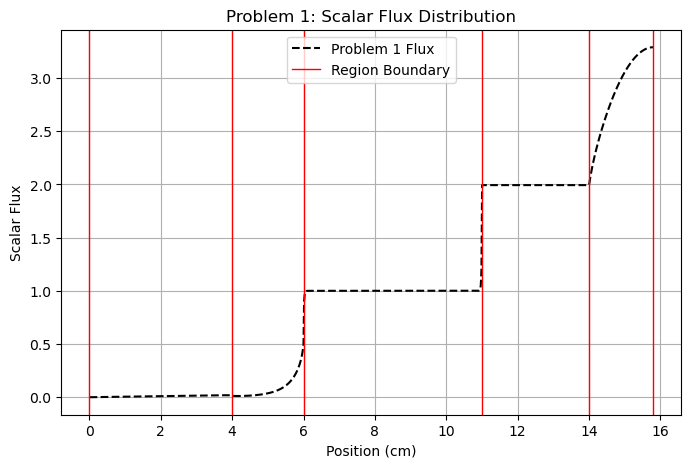

Iteration 1: keff = 1.0062734980819945
Iteration 2: keff = 1.0121532812239464
Iteration 3: keff = 1.0176285213626723
Iteration 4: keff = 1.0227071707558846
Iteration 5: keff = 1.0274203464092828
Iteration 6: keff = 1.0318100741228167
Iteration 7: keff = 1.035918987378424
Iteration 8: keff = 1.0397844618195955
Iteration 9: keff = 1.0434363172237762
Iteration 10: keff = 1.046896739664048
Iteration 11: keff = 1.0501813343754138
Iteration 12: keff = 1.0533005932017574
Iteration 13: keff = 1.056261368205023
Iteration 14: keff = 1.059068153026303
Iteration 15: keff = 1.061724101081284
Iteration 16: keff = 1.0642317792433251
Iteration 17: keff = 1.0665936886752674
Iteration 18: keff = 1.0688125962505612
Iteration 19: keff = 1.0708917204948858
Iteration 20: keff = 1.0728348111722037
Iteration 21: keff = 1.0746461549166493
Iteration 22: keff = 1.0763305324451933
Iteration 23: keff = 1.0778931467043966
Iteration 24: keff = 1.0793395361138405
Iteration 25: keff = 1.080675482903706
Iteration 26: k

/tmp/ipykernel_27870/3015078333.py:132: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x2, phi2, 'k--', marker='none', color='blue', label='Problem 2 Flux')


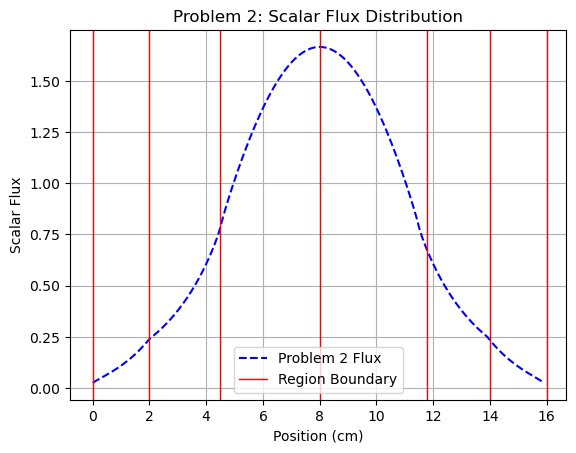

In [2]:

## Step 6. Solve our problem using the Sn method

n = 32
points, weights = np.polynomial.legendre.leggauss(n)
pos_mask = points > 0
neg_mask = points < 0

# Use these masks to extract matching points and weights.

positive_points = points[pos_mask]
positive_weights = weights[pos_mask]

negative_points = points[neg_mask]
negative_weights = weights[neg_mask]



# Reverse the negative arrays so that they go from the largest (in absolute value) to the smallest.

ordered_points = np.concatenate((positive_points, negative_points[::-1]))
ordered_weights = np.concatenate((positive_weights, negative_weights[::-1]))



def main():   #this main definition is where everything happens! its purpose is to define the two transport problems and set up the necessary inputs
#####
    # Problem 1 definition (slab width of 15.8 cm):
    # Region widths: 4.0, 2.0, 5.0, 3.0, 1.8  (total = 15.8 cm)
    # [sigma_a, sigma_s, sigma_f, v_sigma_f, width, source]
    regions1 = np.array([
        [0.0, 10.0, 0.0, 0.0, 4.0, 0.0],   # Region 1: width 4.0 cm
        [1.5,  0.0, 0.0, 0.0, 2.0, 0.0],  # Region 2: width 2.0 cm
        [50.0,  0.0, 0.0, 0.0, 5.0, 50.0],   # Region 3: width 5.0 cm
        [0.0,  0.0, 0.0, 0.0, 3.0, 0.0],  # Region 4: width 3.0 cm
        [0.2,  0.4,  0.15, 0.3, 1.8, 0.0]    # Region 5: width 1.8 cm
    ])

    problem_data1 = {
        "regions":          regions1,
        "cells_per_region": 500,
        "angles":           ordered_points, #np.array([-0.93246951, -0.66120939, -0.23861919,  0.23861919,  0.66120939,  0.93246951]),   #points,     #np.array([0.34, 0.8611, -0.34, -0.8611]),
        "weights":          ordered_weights, #np.array([0.17132449, 0.36076157, 0.46791393, 0.46791393, 0.36076157, 0.17132449]),     #weights,     #np.array([0.6522, 0.3479, 0.6522, 0.3479]),
        "bc_left_type":     "vacuum",
        "bc_right_type":    "reflective",
       # "bc_right_value":   0.0, ######## HOW CAN I MAKE THIS BE THE VALUE THAT WE CALCULATED FOR FINAL_OUT IN STEP 4? I am not sure if that is actually what it is doing here.
        "tolerance":        1e-5,
        "max_iters":        10000,
        "problem_type":     'fs'
    }

    # Problem 2 definition:
    # similarly,     # Region widths: 2, 2.5, 3.5, 3.6, 2.4, 2   (total = 16 cm)
    # [sigma_a, sigma_s, sigma_f, v_sigma_f, width, source]
    regions2 = np.array([
        [0.1,  1.5, 0.0,     0.0,    2.0, 0.0],   # Region 1
        [0.2,  0.8, 0.0625,  0.1375, 2.5, 0.0],   # Region 2
        [0.18, 1.0, 0.09375, 0.225,  3.5, 0.0],     # Region 3
        [0.18, 1.0, 0.09375, 0.225,  3.5, 0.0],     #Region 3.1
        [0.2,  0.8, 0.0625,  0.1375, 2.4, 0.0],    #region 2.1
        [0.1,  1.5, 0.0,     0.0,    2.0, 0.0]     #region 1.1
    ])



    problem_data2 = {
        "regions":          regions2,
        "cells_per_region": 500,
        "angles":           ordered_points, # np.array([-0.93246951, -0.66120939, -0.23861919,  0.23861919,  0.66120939,  0.93246951]),   #points,     #np.array([0.34, 0.8611, -0.34, -0.8611]),
        "weights":          ordered_weights, # np.array([0.17132449, 0.36076157, 0.46791393, 0.46791393, 0.36076157, 0.17132449]),     #weights,     #np.array([0.6522, 0.3479, 0.6522, 0.3479]),
        "bc_left_type":     "vacuum",
        "bc_right_type":    "vacuum",    #no flux enters from either side
        "tolerance":        1e-10,
        "max_iters":        10000,
        "problem_type":     'ev'
    }


    # Solve Problem 1
    phi1, x1 = solve_1d_transport(problem_data1)
    print("\nFinal scalar flux distribution for Problem 1:")
    print(phi1,x1)   #this prints the final scalar flux values for problem 1, and the associated x values with those fluxes



    # --------------------------

    # Plotting the results for both problems.

    # --------------------------

    fig, axes = plt.subplots(1, 1, figsize=(8,5))

        #this creates a figure with two sublots arranged vertically

        # figsizeargument specifies the overall size of image



    # Plot Problem 1 results.
    plt.plot(x1, phi1, 'k--', marker='none', color='black', label='Problem 1 Flux')
    plt.xlabel("Position (cm)")
    plt.ylabel("Scalar Flux")
    plt.title("Problem 1: Scalar Flux Distribution")
    plt.grid(True)

    # Overlay region boundaries: x = 0, 4, 6, 11, 14, 15.8 cm
    region_boundaries = np.array([0, 4, 6, 11, 14, 15.8])

    for i, rb in enumerate(region_boundaries):
        if i == 1:
            plt.axvline(x=rb, color='red', linestyle='-', linewidth=1.0, label='Region Boundary')
        else:
            plt.axvline(x=rb, color='red', linestyle='-', linewidth=1.0)



    plt.legend()
    plt.show()



    # Solve Problem 2
    phi2, x2 = solve_1d_transport(problem_data2)
    print("\nFinal scalar flux distribution for Problem 2:")
    print(phi2,x2)





    # Plot Problem 2 results.
    plt.plot(x2, phi2, 'k--', marker='none', color='blue', label='Problem 2 Flux')
    plt.xlabel("Position (cm)")
    plt.ylabel("Scalar Flux")
    plt.title("Problem 2: Scalar Flux Distribution")
    plt.grid(True)

    region_boundaries = np.array([0, 2, 4.5, 8, 11.8, 14, 16])

    for i, rb in enumerate(region_boundaries):
        if i == 1:
            plt.axvline(x=rb, color='red', linestyle='-', linewidth=1.0, label='Region Boundary')
        else:
            plt.axvline(x=rb, color='red', linestyle='-', linewidth=1.0)
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()    #this is helpful becuase it allows you to run it as a module, as opposed to just directly executing the code. It helps for applying it to other problems/users





